# Modelli di classificazione

In questa parte del progetto, l'obiettivo è classificare le zone urbane nel comune di Trento, utilizzando modelli di classificazione. Si analizzano i dati relativi a tre fasce orarie specifiche: la fascia giornaliera (9-18),quella notturna (18-24) e la fascia 18-19. Per individuare le zone urbane, si fa riferimento alla potenza media erogata. Le zone vengono etichettate come urbane o non urbane tramite la colonna 'HIGH_POW'. In particolare, le zone urbane sono identificate come positive ('HIGH_POW' = 1), mentre le zone periferiche come negative ('HIGH_POW' = 0).
La classe dei positivi contiene circa il doppio degli elementi rispetto alla classe dei negativi,perciò bisognerà anche tenere in considerazione il leggero sbilanciamento tra le classi durante l'allenamento dei modelli.

La classificazione delle zone urbane è di grande interesse in quanto fornisce informazioni fondamentali per comprendere e analizzare il consumo energetico nelle diverse aree del comune di Trento. Questa suddivisione permette di individuare le zone con una maggiore concentrazione di attività e infrastrutture urbane, che generalmente presentano un consumo energetico più elevato. L'utilizzo di modelli di classificazione consente di identificare e distinguere in modo accurato le zone urbane dalle zone periferiche, facilitando ulteriori analisi e previsioni legate al consumo energetico e alla pianificazione urbana.



In [1]:
import pandas as pd
import numpy as np
import geopandas as gp
from datetime import datetime
from datetime import date
import seaborn as sns
import ydata_profiling as yp
from ydata_profiling import ProfileReport 
%matplotlib inline

Cominciamo caricando i dataset contenenti le potenze medie nella fascia oraria 9-18 creati precedentemente

In [61]:
df_day_trento_nov=pd.read_csv("class/df_day_trento_nov.csv")
df_day_trento_nov.drop(columns=['Unnamed: 0','SAB','DOM','TRENTO'],inplace=True)
df_day_trento_dec=pd.read_csv("class/df_day_trento_nov.csv")
df_day_trento_dec.drop(columns=['Unnamed: 0','SAB','DOM','TRENTO'],inplace=True)
df_day_trento=pd.concat([df_day_trento_nov, df_day_trento_dec], ignore_index=True)
df_day_trento

,SQUAREID,DAY,DAY_ID,LUN,MAR,MER,GIO,VEN,SQUARE_UBICAZIONI,NR_LINES,DAWN,SUNSET,DAYLENGHT,minTemperature,maxTemperature,POWER,HIGH_POW
0,4850,1,4,0,0,0,0,1,285,5,417,1020,603,11.7,16.0,18.177452,0
1,4850,4,0,1,0,0,0,0,285,5,421,1016,594,7.4,9.8,23.338705,1
2,4850,5,1,0,1,0,0,0,285,5,422,1014,592,7.5,15.4,21.874364,1
3,4850,6,2,0,0,1,0,0,285,5,424,1013,589,7.9,14.3,21.773714,1
4,4850,7,3,0,0,0,1,0,285,5,425,1012,586,6.1,15.6,21.426790,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1171,5552,25,0,1,0,0,0,0,133,1,450,994,543,2.4,10.4,7.722336,0
1172,5552,26,1,0,1,0,0,0,133,1,451,993,541,2.4,6.7,7.923465,0
1173,5552,27,2,0,0,1,0,0,133,1,453,992,539,-0.3,4.9,8.064573,0
1174,5552,28,3,0,0,0,1,0,133,1,454,992,538,-2.6,5.0,7.927466,0


Facciamo un profile report sui dati per vedere eventuali correlazioni tra essi

In [107]:
report=ProfileReport(df_day_trento,title='Dati originali')
report.to_file('dati_class_trento.html')


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

Controlliamo che il dataset non contenga valori nulli

In [3]:
df_day_trento.isnull().sum()

SQUAREID             0
DAY                  0
DAY_ID               0
LUN                  0
MAR                  0
MER                  0
GIO                  0
VEN                  0
SQUARE_UBICAZIONI    0
NR_LINES             0
DAWN                 0
SUNSET               0
DAYLENGHT            0
minTemperature       0
maxTemperature       0
POWER                0
HIGH_POW             0
dtype: int64

A questo punto, procediamo alla divisione del dataset in X e Y. X rappresenta i dati utilizzati come input per i modelli di classificazione. Dalla matrice X, rimuoviamo i parametri di identità come 'SQUAREID' e 'DAY' al fine di evitare un'eccessiva complessità del modello. Inoltre, escludiamo anche i parametri 'DAWN' e 'SUNSET', poiché sono altamente correlati alla lunghezza del giorno.
Y invece, rappresenta la variabile dipendente che si desidera classificare, in questo caso l'etichetta che indica se una zona è urbana o non urbana.

Successivamente, procediamo alla suddivisione delle matrici X e Y in tre sottoinsiemi: train, valid e test. Questa divisione è un'importante pratica nel campo dell'apprendimento automatico per valutare l'efficacia dei modelli e garantire una corretta generalizzazione.

Il sottoinsieme di addestramento (train) viene utilizzato per addestrare il modello sui dati disponibili, consentendogli di apprendere i pattern e le relazioni tra le variabili indipendenti (X) e la variabile dipendente (Y). Questo è il set di dati su cui il modello regolerà i suoi parametri al fine di ottimizzare la performance.

Il sottoinsieme di validazione (valid) viene utilizzato per valutare le prestazioni del modello durante la fase di addestramento. Utilizzando i dati di validazione, possiamo monitorare la capacità del modello di generalizzare e identificare eventuali problemi come l'overfitting o l'underfitting. Questo ci permette di apportare eventuali modifiche o regolazioni al modello per migliorarne le prestazioni.

Infine, il sottoinsieme di test (test) viene utilizzato per valutare le prestazioni finali del modello una volta che è stato completamente addestrato e ottimizzato. Questo set di dati è indipendente dai dati di addestramento e validazione e viene utilizzato per valutare l'accuratezza del modello in situazioni reali.

In [4]:
from sklearn import datasets
from sklearn.linear_model import Ridge, Lasso, LinearRegression, LassoCV, RidgeCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import mean_squared_error
X=df_day_trento.drop(columns=['SQUAREID','POWER','DAY','DAWN','SUNSET','HIGH_POW'])
scal = StandardScaler()
Y=df_day_trento['HIGH_POW']
X_train,X_other,Y_train,Y_other=train_test_split(X,Y,test_size=0.4,random_state=0)
X_valid = X_other[:len(X_other)//2]
X_test = X_other[len(X_other)//2:]
Y_valid = Y_other[:len(Y_other)//2]
Y_test = Y_other[len(Y_other)//2:]
scal.fit(X)
X_train=scal.transform(X_train)
X_valid=scal.transform(X_valid)
X_test=scal.transform(X_test)


In [5]:
from  sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
from sklearn.metrics import f1_score

A questo punto creiamo il primo classificatore con regolarizzazione elasticnet e lo alleniamo con i dati di train

In [6]:
LR_day = LogisticRegressionCV(penalty='elasticnet',solver='saga',l1_ratios=[0,0.25,0.5,0.75,1.0],max_iter=2000,tol=0.001,cv=20)

In [7]:
LR_day.fit(X_train,Y_train)


LogisticRegressionCV(cv=20, l1_ratios=[0, 0.25, 0.5, 0.75, 1.0], max_iter=2000,
                     penalty='elasticnet', solver='saga', tol=0.001)

Visualizziamo l'importanza delle features del modello tramite un istogramma

Text(0.5, 1.0, 'Pesi LR_day')

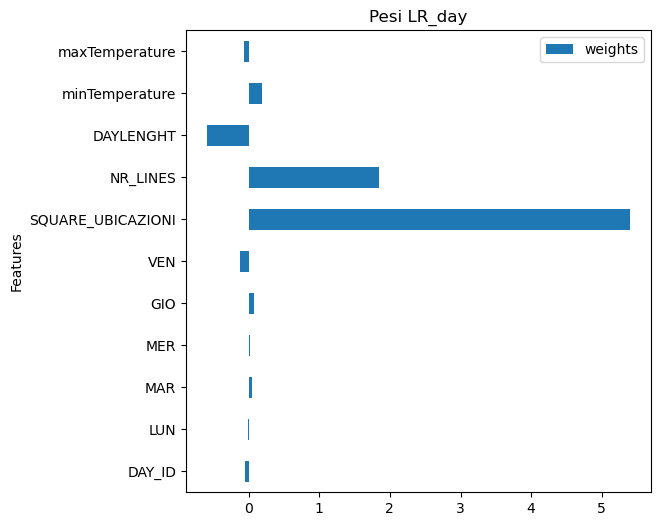

In [8]:
features = X.columns.to_numpy().reshape(-1)  # Reshape to 1-dimensional array
weights = LR_day.coef_.flatten()  # Flatten the coefficients array
df_w = pd.DataFrame({'features': features, 'weights': weights})
ax = df_w.plot.barh(y='weights', x='features', figsize=(6, 6))
ax.set_ylabel('Features')
ax.set_title('Pesi LR_day')

I parametri più importanti per la classificazione delle zone urbane sono il numero di ubicazioni, il numero di linee collegate e la lunghezza del giorno corrente. Questi parametri hanno senso poiché nelle zone urbane ci aspettiamo che, in media, il consumo di potenza aumenti con l'aumento delle ubicazioni presenti.

La presenza di un maggior numero di ubicazioni in una determinata zona urbana indica una maggiore densità di attività residenziali e commerciali, che a loro volta richiedono un maggiore consumo di energia elettrica. Quindi, è ragionevole aspettarsi che il numero di ubicazioni sia il fattore più importante nella classificazione delle zone urbane.

Definiamo ora tre funzioni utili per la valutazione dei modelli:

* **evaluate_classifier()**: Questa funzione stampa alcuni parametri di valutazione, come l'accuratezza, la precisione e lo score F1. Questi parametri vengono calcolati per il modello model dati due dataset X e Y. La funzione fornisce una panoramica delle prestazioni del modello e permette di valutare la sua capacità di classificazione.

* **plot_roc_curve()**: Questa funzione, dati due modelli, crea un grafico in cui vengono confrontate le rispettive curve ROC (Receiver Operating Characteristic) e le AUC (Area Under the Curve). La curva ROC rappresenta il trade-off tra il tasso di vero positivo (True Positive Rate) e il tasso di falso positivo (False Positive Rate), mentre l'AUC fornisce una misura della capacità predittiva del modello. Dall'analisi delle curve ROC e dei valori di AUC, è possibile dedurre quale modello sia migliore nella classificazione.

* **disp_cf()**: Questa funzione crea la matrice di confusione di un modello dati i dataset X e Y. La matrice di confusione visualizza il numero di veri positivi, falsi positivi, veri negativi e falsi negativi del modello, consentendo una valutazione dettagliata delle sue performance di classificazione. La matrice di confusione è uno strumento fondamentale per comprendere come il modello stia classificando correttamente e erroneamente le istanze.

In [9]:
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

def evaluate_classifier(model, X, Y):
    # Make predictions on the validation data
    y_pred = model.predict(X)
    conf_mat = metrics.confusion_matrix(Y, y_pred)
    # Calculate evaluation metrics
    accuracy = metrics.accuracy_score(Y, y_pred)
    precision = metrics.precision_score(Y, y_pred)
    recall = metrics.recall_score(Y, y_pred)
    f1_score = metrics.f1_score(Y, y_pred)
    
    
    # Calculate true positive rate and false positive rate
    tn, fp, fn, tp = conf_mat.ravel()
    tpr = tp / (tp + fn)
    fpr = fp / (fp + tn)
    
    # Print the evaluation metrics
    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1_score)
    print("True Positive Rate:", tpr)
    print("False Positive Rate:", fpr)


def plot_roc_curve(model1, model2, X, Y):
    # Calculate the predicted probabilities for class 1
    y_pred_prob1 = model1.predict_proba(X)[:, 1]
    y_pred_prob2 = model2.predict_proba(X)[:, 1]
    
    # Compute the false positive rate (FPR), true positive rate (TPR), and thresholds for model1
    fpr1, tpr1, thresholds1 = roc_curve(Y, y_pred_prob1)
    roc_auc1 = auc(fpr1, tpr1)
    
    # Compute the false positive rate (FPR), true positive rate (TPR), and thresholds for model2
    fpr2, tpr2, thresholds2 = roc_curve(Y, y_pred_prob2)
    roc_auc2 = auc(fpr2, tpr2)
    
    # Plot ROC curve for model1
    plt.plot(fpr1, tpr1, label='Model 1 (AUC = %0.2f)' % roc_auc1)
    
    # Plot ROC curve for model2
    plt.plot(fpr2, tpr2, label='Model 2 (AUC = %0.2f)' % roc_auc2)
    
    # Plot diagonal line (random classifier)
    plt.plot([0, 1], [0, 1], 'k--')
    
    # Set plot labels and title
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Confronto ROC')
    
    # Show legend
    plt.legend(loc='lower right')
    
    # Show the plot
    plt.show()
    
    # Print AUC for both models
    print("Model 1 AUC:", roc_auc1)
    print("Model 2 AUC:", roc_auc2)

def disp_cf(model,X,Y):
    y_pred = model.predict(X)
    cm = confusion_matrix(Y,y_pred, labels=model.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model.classes_)
    disp.plot()

Valutiamo il classificatore creato e creiamo la matrice di confusione

In [10]:
evaluate_classifier(LR_day, X_valid, Y_valid)

Accuracy: 0.8765957446808511
Precision: 0.8859060402684564
Recall: 0.9166666666666666
F1 Score: 0.901023890784983
True Positive Rate: 0.9166666666666666
False Positive Rate: 0.18681318681318682


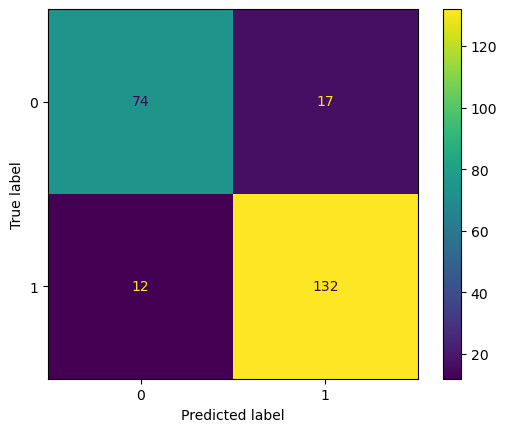

In [11]:
disp_cf(LR_day, X_valid, Y_valid)

Il risultato della matrice di confusione mostra che il modello ha classificato correttamente 74 zone come negative (veri negativi) e 132 zone come positivi (veri positivi). Tuttavia, ci sono stati 17 casi in cui il modello ha erroneamente classificato una zona come positiva quando in realtà era negativa (falsi positivi) e 12 casi in cui ha erroneamente classificato una zona come negativa quando in realtà era positiva (falsi negativi).

Questo risultato suggerisce che il modello ha una buona capacità di identificare correttamente le istanze negative, ma può migliorare nella classificazione delle istanze positive.

Per trovare il modello ottimale per la nostra classificazione, stiamo utilizziamo una tecnica chiamata GridSearch. Questo metodo ci consente di esplorare diverse combinazioni di iperparametri per un determinato modello e valutare quale combinazione produce le migliori prestazioni.

Nella nostra GridSearch, specifichiamo una griglia di valori per gli iperparametri del modello. In particolare scegliamo come iperparametri il tipo di regolarizzazione (l1 o l2),un insieme di pesi per la regolarizzazione,il peso delle classi(Nessuno o bilanciato) e il metodo solver (saga o liblinear)

In [12]:
from sklearn.preprocessing import StandardScaler
log_reg = LogisticRegression(solver='saga', max_iter=2000, tol=0.0001)
scaler = StandardScaler()
pipe_lr = Pipeline([('scaler',scaler), ('logreg',log_reg)])

In [13]:
from sklearn.preprocessing import StandardScaler
log_reg = LogisticRegression(solver='saga', max_iter=2000, tol=0.0001)
scaler = StandardScaler()
pipe_lr = Pipeline([('scaler', scaler), ('logreg', log_reg)])

# Define the hyperparameter grid
param_grid = {
    'logreg__penalty': ['l1', 'l2'],
    'logreg__C':  np.logspace(-2,2,num=10),
    'logreg__class_weight': [None, 'balanced'],
    'logreg__solver': ['liblinear', 'saga'],
}


Definiamo una funzione che seleziona il modello migliore della GridSearch

In [14]:
def train_regression_model(regressor, param_grid, cv, X, y):
    grid_search = GridSearchCV(regressor, param_grid, cv=cv)
    grid_search.fit(X, y)

    # Print the best parameters
    best_params = grid_search.best_params_
    print("Best parameters:", best_params)

    best_regressor = grid_search.best_estimator_  # Get the best estimator

    return best_regressor

Stampiamo i parametri del modello migliore

In [15]:
best_lr_day=train_regression_model(pipe_lr,param_grid,10,X_train,Y_train)

Best parameters: {'logreg__C': 0.0774263682681127, 'logreg__class_weight': 'balanced', 'logreg__penalty': 'l1', 'logreg__solver': 'saga'}


In [16]:
best_lr_day.score(X_valid,Y_valid)

0.902127659574468

In [17]:
evaluate_classifier(best_lr_day, X_valid, Y_valid)

Accuracy: 0.902127659574468
Precision: 0.9230769230769231
Recall: 0.9166666666666666
F1 Score: 0.9198606271777002
True Positive Rate: 0.9166666666666666
False Positive Rate: 0.12087912087912088


Confrontiamo le curve Roc e le Auc dei due classificatori

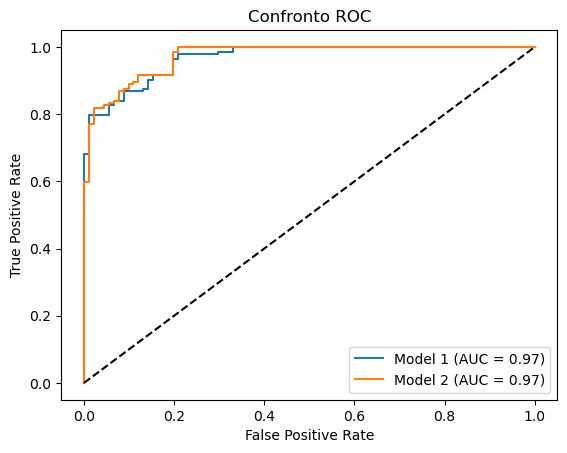

Model 1 AUC: 0.9676434676434675
Model 2 AUC: 0.9718406593406593


In [18]:
plot_roc_curve(LR_day, best_lr_day, X_valid, Y_valid)

Il classificatore "best_lr_day" mostra una leggera miglior performance rispetto al modello precedentemente allenato, come evidenziato dall'AUC (Area Under the Curve) della curva ROC. Questo suggerisce che il nostro nuovo modello è in grado di fornire una maggiore discriminazione tra le classi positive e negative. Pertanto, procediamo focalizzandoci esclusivamente sull'ultimo modello creato per ulteriori analisi e valutazioni

In [19]:
pr,rec, th = precision_recall_curve(Y_valid,  best_lr_day.predict_proba(X_valid)[:,1])

Visualizziamo adesso l'andamento della precisione e della recall in funzione della threshold

Text(0, 0.5, 'recall')

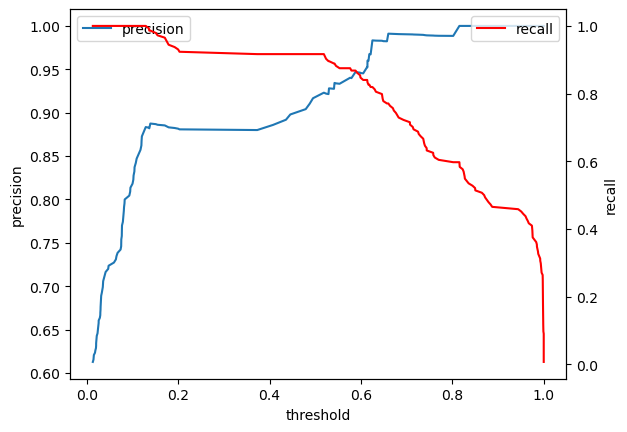

In [20]:
ax = sns.lineplot(x=th, y =pr[:-1], label='precision')
ax2 = sns.lineplot(x=th,y=rec[:-1],label='recall',ax=ax.twinx(),color='red')
ax.set_xlabel('threshold')
ax.set_ylabel('precision')
ax2.set_ylabel('recall')

A questo punto, miriamo a individuare la soglia (threshold) che minimizza il numero di falsi negativi. Questa scelta è motivata dal fatto che nel contesto del nostro progetto, è preferibile accettare la presenza di falsi positivi piuttosto che falsi negativi. Se i falsi negativi fossero più numerosi dei falsi positivi, ciò comporterebbe una sottovalutazione del consumo nella zona urbana di Trento e, di conseguenza, l'energia elettrica fornita basandosi su questo modello non sarebbe sufficiente per soddisfare la domanda. Pertanto, stiamo cercando la soglia che massimizza l'f1 score, un indicatore che tiene conto simultaneamente di precisione e richiamo, al fine di ottenere un equilibrio tra le due misure e trovare un punto di ottimizzazione.

In [21]:
from sklearn.metrics import precision_recall_curve, auc
f1_scores = 2 * (pr * rec) / (pr + rec)
best_threshold = th[np.argmax(f1_scores)]
print("Best Threshold:", best_threshold)

Best Threshold: 0.12869251648016888


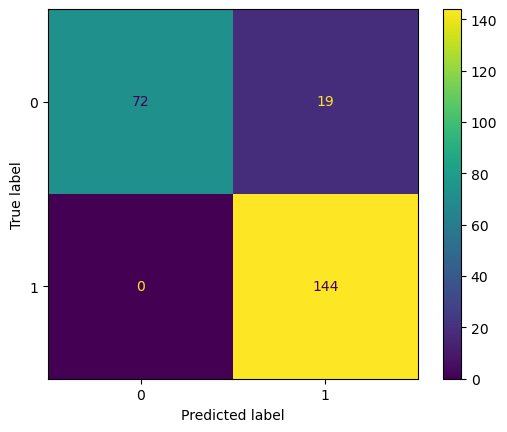

In [22]:
y_prob =  best_lr_day.predict_proba(X_valid)[:, 1]
y_pred = (y_prob >= best_threshold).astype(int)
cm = confusion_matrix(Y_valid,y_pred, labels= best_lr_day.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                           display_labels= best_lr_day.classes_)
disp.plot()

Dalla nuova matrice di confusione possiamo constatare che siamo riusciti a ottenere un risultato soddisfacente. La maggior parte delle zone è stata correttamente classificata, Osserviamo che non c'è nessuna zona che, in una specifica giornata, erroneamente classificata come falso negativo. Il modello mostra una buona capacità di individuare le zone urbane,

A questo punto rifacciamo il train su l'insieme train + valid, e valutiamo il modello confrontandolo con i dati test

In [23]:
X_final=np.concatenate([X_train, X_valid])
Y_final=np.concatenate([Y_train, Y_valid])
best_lr_day.fit(X_final,Y_final)

Pipeline(steps=[('scaler', StandardScaler()),
                ('logreg',
                 LogisticRegression(C=0.0774263682681127,
                                    class_weight='balanced', max_iter=2000,
                                    penalty='l1', solver='saga'))])

In [24]:
evaluate_classifier(best_lr_day, X_test, Y_test)

Accuracy: 0.8983050847457628
Precision: 0.9246575342465754
Recall: 0.9121621621621622
F1 Score: 0.9183673469387755
True Positive Rate: 0.9121621621621622
False Positive Rate: 0.125


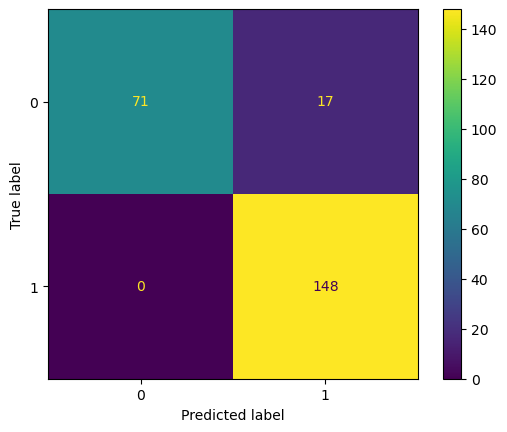

In [25]:
y_prob =  best_lr_day.predict_proba(X_test)[:, 1]
y_pred = (y_prob >= best_threshold).astype(int)
cm = confusion_matrix(Y_test,y_pred, labels= best_lr_day.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                           display_labels= best_lr_day.classes_)
disp.plot()

Dalla matrice di confusione ottenuta sui dati di test, possiamo osservare che la distribuzione degli elementi è simile a quella precedentemente mostrata durante la valutazione del modello. Questo risultato ci permette di concludere che il nostro modello è in grado di effettuare predizioni accurate anche su dati che non sono mai stati utilizzati durante il processo di addestramento e di validazione.

A questo punto, procediamo alla visualizzazione delle zone predette dal modello sulla mappa. Per fare ciò, creiamo una nuova colonna booleana chiamata 'PRED' in cui inseriamo i valori previsti dal modello. Successivamente, raggruppiamo il dataset calcolando la media dei valori previsti per ogni zona durante i mesi di novembre e dicembre. Infine, in base ai valori reali e previsti, classifichiamo ogni zona come vera o falsa e mostriamo queste informazioni sulla mappa di Trento. In questo modo, sarà possibile valutare visivamente l'accuratezza delle previsioni del modello e confrontarle con la realtà delle zone urbane nella città.

In [26]:
y_prob =  best_lr_day.predict_proba(scal.transform(X))[:, 1]
df_day_trento['PRED']=(y_prob >= best_threshold).astype(int)
df_day_trento.groupby(["SQUAREID","HIGH_POW"])[["PRED"]].mean().reset_index()

,SQUAREID,HIGH_POW,PRED
0,4850,0,1.0
1,4850,1,1.0
2,4966,0,1.0
3,4966,1,1.0
4,4967,1,1.0
5,4968,0,1.0
6,4968,1,1.0
7,5082,0,0.0
8,5083,1,1.0
9,5084,1,1.0


In [27]:
import geopandas as gpd
df_grid = gp.read_file("./data_trentino/raw/trentino-grid.geojson")
df_grid = df_grid.rename(columns={"cellId": "SQUAREID"})
df_grid[['SQUAREID','geometry']]
df_grid=df_grid.merge(df_day_trento[["SQUAREID","HIGH_POW",'PRED']],on='SQUAREID',how='left')
df_grid

,SQUAREID,geometry,HIGH_POW,PRED
0,38,"POLYGON ((10.91462 45.68201, 10.92746 45.68179...",NaN,NaN
1,39,"POLYGON ((10.92746 45.68179, 10.94029 45.68157...",NaN,NaN
2,40,"POLYGON ((10.94029 45.68157, 10.95312 45.68136...",NaN,NaN
3,154,"POLYGON ((10.90209 45.69122, 10.91493 45.69100...",NaN,NaN
4,155,"POLYGON ((10.91493 45.69100, 10.92777 45.69079...",NaN,NaN
...,...,...,...,...
7718,11336,"POLYGON ((11.80475 46.52767, 11.81777 46.52735...",NaN,NaN
7719,11337,"POLYGON ((11.81777 46.52735, 11.83080 46.52703...",NaN,NaN
7720,11452,"POLYGON ((11.79219 46.53698, 11.80521 46.53666...",NaN,NaN
7721,11453,"POLYGON ((11.80521 46.53666, 11.81824 46.53634...",NaN,NaN


In [28]:
df_grid['Category'] = 'Unknown'  

df_grid.loc[(df_grid['HIGH_POW'] > 0.5) & (df_grid['PRED'] > 0.5), 'Category'] = 'Real Positive'
df_grid.loc[(df_grid['HIGH_POW'] > 0.5) & (df_grid['PRED'] < 0.5), 'Category'] = 'False Negative'
df_grid.loc[(df_grid['HIGH_POW'] <0.5) & (df_grid['PRED'] > 0.5), 'Category'] = 'False Positive'
df_grid.loc[(df_grid['HIGH_POW'] < 0.5) & (df_grid['PRED'] < 0.5), 'Category'] = 'Real Negative'

df_grid.dropna(inplace=True)

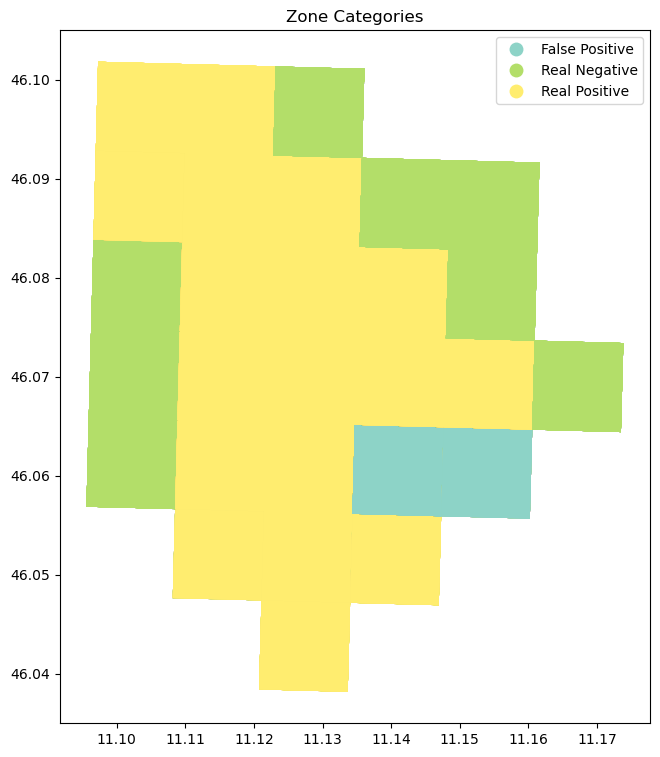

In [29]:
import matplotlib.patches as mpatches
fig, ax = plt.subplots(figsize=(9, 9))

df_grid.plot(column='Category', legend=True,ax=ax, cmap='Set3')

ax.set_title('Zone Categories')

# Plot the custom legend

plt.show()

Osservando la mappa delle previsioni, possiamo notare che sono presenti solo due zone catalogate come falsi positivi, ovvero erroneamente identificate come zone urbane. Al contrario, non sono presenti zone classificate come falsi negativi, ossia zone urbane che sono state erroneamente considerate come zone non urbane. Questo risultato suggerisce che il modello ha una buona capacità di identificare correttamente le zone urbane, riducendo al minimo i falsi negativi.

Ripetiamo lo stesso procedimento con le zone della fascia oraria notturna

In [36]:
df_night_trento_nov=pd.read_csv("class/df_night_trento_nov.csv")
df_night_trento_nov.drop(columns=['Unnamed: 0','SAB','DOM','TRENTO'],inplace=True)
df_night_trento_dec=pd.read_csv("class/df_night_trento_nov.csv")
df_night_trento_dec.drop(columns=['Unnamed: 0','SAB','DOM','TRENTO'],inplace=True)
df_night_trento=pd.concat([df_night_trento_nov, df_night_trento_dec], ignore_index=True)
df_night_trento['HIGH_POW']=df_day_trento['HIGH_POW']
df_night_trento

,SQUAREID,DAY,DAY_ID,LUN,MAR,MER,GIO,VEN,SQUARE_UBICAZIONI,NR_LINES,DAWN,SUNSET,DAYLENGHT,minTemperature,maxTemperature,POWER,HIGH_POW
0,4850,1,4,0,0,0,0,1,285,5,417,1020,603,11.7,16.0,18.654491,0
1,4850,4,0,1,0,0,0,0,285,5,421,1016,594,7.4,9.8,20.159526,1
2,4850,5,1,0,1,0,0,0,285,5,422,1014,592,7.5,15.4,20.001810,1
3,4850,6,2,0,0,1,0,0,285,5,424,1013,589,7.9,14.3,19.875357,1
4,4850,7,3,0,0,0,1,0,285,5,425,1012,586,6.1,15.6,20.866417,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1171,5552,25,0,1,0,0,0,0,133,1,450,994,543,2.4,10.4,6.911507,0
1172,5552,26,1,0,1,0,0,0,133,1,451,993,541,2.4,6.7,6.945511,0
1173,5552,27,2,0,0,1,0,0,133,1,453,992,539,-0.3,4.9,6.951886,0
1174,5552,28,3,0,0,0,1,0,133,1,454,992,538,-2.6,5.0,6.935628,0


In [37]:
df_night_trento.isnull().sum()

SQUAREID             0
DAY                  0
DAY_ID               0
LUN                  0
MAR                  0
MER                  0
GIO                  0
VEN                  0
SQUARE_UBICAZIONI    0
NR_LINES             0
DAWN                 0
SUNSET               0
DAYLENGHT            0
minTemperature       0
maxTemperature       0
POWER                0
HIGH_POW             0
dtype: int64

In [38]:
X=df_night_trento.drop(columns=['SQUAREID','POWER','DAY','DAWN','SUNSET','HIGH_POW'])
scal = StandardScaler()
Y=df_night_trento['HIGH_POW']
X_train,X_other,Y_train,Y_other=train_test_split(X,Y,test_size=0.4,random_state=0)
X_valid = X_other[:len(X_other)//2]
X_test = X_other[len(X_other)//2:]
Y_valid = Y_other[:len(Y_other)//2]
Y_test = Y_other[len(Y_other)//2:]
scal.fit(X)
X_train=scal.transform(X_train)
X_valid=scal.transform(X_valid)
X_test=scal.transform(X_test)


A questo punto creiamo il primo classificatore con regolarizzazione elasticnet e lo alleniamo con i dati di train

In [39]:
LR_night = LogisticRegressionCV(penalty='elasticnet',solver='saga',l1_ratios=[0,0.25,0.5,0.75,1.0],max_iter=2000,tol=0.001,cv=20)

In [40]:
LR_night.fit(X_train,Y_train)


LogisticRegressionCV(cv=20, l1_ratios=[0, 0.25, 0.5, 0.75, 1.0], max_iter=2000,
                     penalty='elasticnet', solver='saga', tol=0.001)

Visualizziamo l'importanza delle features del modello tramite un istogramma

Text(0.5, 1.0, 'Pesi LR_night')

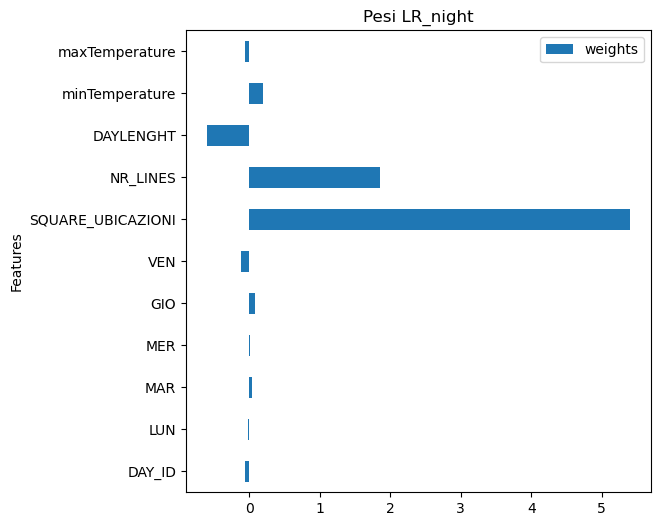

In [41]:
features = X.columns.to_numpy().reshape(-1)  # Trasformo l'array in un vettore unidimensionale
weights = LR_night.coef_.flatten()  
df_w = pd.DataFrame({'features': features, 'weights': weights})
ax = df_w.plot.barh(y='weights', x='features', figsize=(6, 6))
ax.set_ylabel('Features')
ax.set_title('Pesi LR_night')

L'importanza delle features ha un andamento molto simile al modello per la previsione dei dati della fascia oraria 9-18

Valutiamo il classificatore creato e creiamo la matrice di confusione

In [42]:
evaluate_classifier(LR_night, X_valid, Y_valid)

Accuracy: 0.8765957446808511
Precision: 0.8859060402684564
Recall: 0.9166666666666666
F1 Score: 0.901023890784983
True Positive Rate: 0.9166666666666666
False Positive Rate: 0.18681318681318682


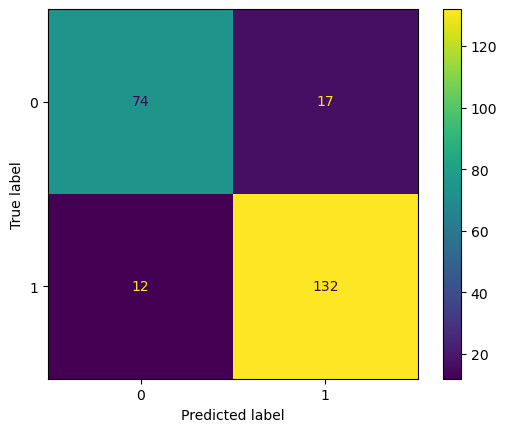

In [43]:
disp_cf(LR_night, X_valid, Y_valid)

In questo caso la matrice di confusione è identica a quella ottenuta precedentemente

Come fatto in precedenza,cerchiamo il modello ottimale tramite una GridSearch

Stampiamo i parametri del modello migliore

In [44]:
best_lr_night=train_regression_model(pipe_lr,param_grid,10,X_train,Y_train)

Best parameters: {'logreg__C': 0.0774263682681127, 'logreg__class_weight': 'balanced', 'logreg__penalty': 'l1', 'logreg__solver': 'saga'}


In [45]:
best_lr_night.score(X_valid,Y_valid)

0.902127659574468

In [46]:
evaluate_classifier(best_lr_night, X_valid, Y_valid)

Accuracy: 0.902127659574468
Precision: 0.9230769230769231
Recall: 0.9166666666666666
F1 Score: 0.9198606271777002
True Positive Rate: 0.9166666666666666
False Positive Rate: 0.12087912087912088


Confrontiamo le curve Roc e le Auc dei due classificatori

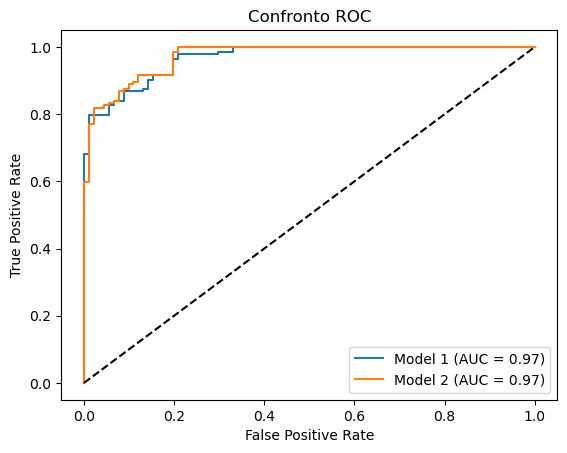

Model 1 AUC: 0.9676434676434675
Model 2 AUC: 0.9718406593406593


In [47]:
plot_roc_curve(LR_night, best_lr_night, X_valid, Y_valid)

Anche in questo caso il modello trovato con la GridSearch è leggermente migliore rispetto a 'LR_night'

In [48]:
pr,rec, th = precision_recall_curve(Y_valid,  best_lr_night.predict_proba(X_valid)[:,1])

Visualizziamo adesso l'andamento della precisione e della recall in funzione della threshold

Text(0, 0.5, 'recall')

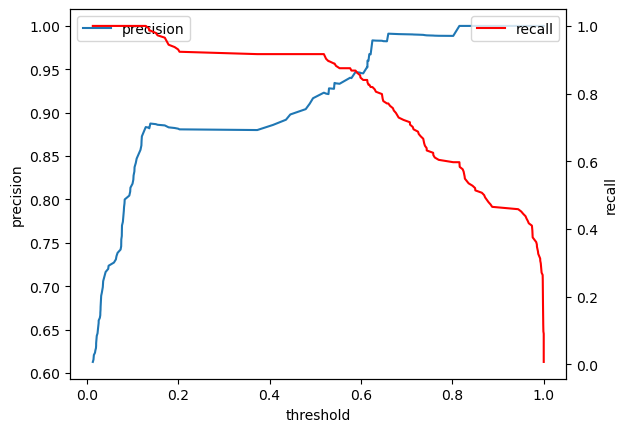

In [49]:
ax = sns.lineplot(x=th, y =pr[:-1], label='precision')
ax2 = sns.lineplot(x=th,y=rec[:-1],label='recall',ax=ax.twinx(),color='red')
ax.set_xlabel('threshold')
ax.set_ylabel('precision')
ax2.set_ylabel('recall')

Come fatto in precedenza,cerchiamo la soglia che masimizza lo score f1

In [50]:
f1_scores = 2 * (pr * rec) / (pr + rec)
best_threshold = th[np.argmax(f1_scores)]
print("Best Threshold:", best_threshold)

Best Threshold: 0.12870808452469426


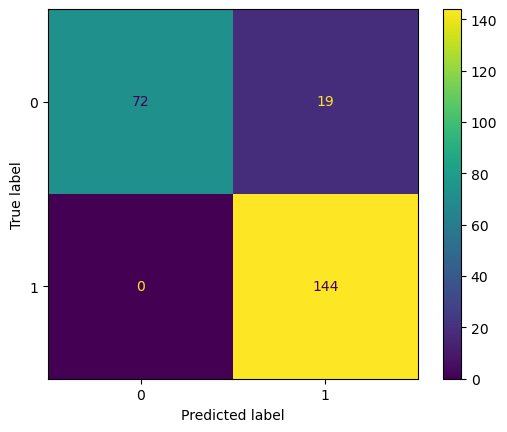

In [51]:
y_prob =  best_lr_night.predict_proba(X_valid)[:, 1]
y_pred = (y_prob >= best_threshold).astype(int)
cm = confusion_matrix(Y_valid,y_pred, labels= best_lr_day.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                           display_labels= best_lr_day.classes_)
disp.plot()

A questo punto rifacciamo il train su l'insieme train + valid, e valutiamo il modello confrontandolo con i dati test

In [52]:
X_final=np.concatenate([X_train, X_valid])
Y_final=np.concatenate([Y_train, Y_valid])
best_lr_night.fit(X_final,Y_final)

Pipeline(steps=[('scaler', StandardScaler()),
                ('logreg',
                 LogisticRegression(C=0.0774263682681127,
                                    class_weight='balanced', max_iter=2000,
                                    penalty='l1', solver='saga'))])

In [53]:
evaluate_classifier(best_lr_night, X_test, Y_test)

Accuracy: 0.8983050847457628
Precision: 0.9246575342465754
Recall: 0.9121621621621622
F1 Score: 0.9183673469387755
True Positive Rate: 0.9121621621621622
False Positive Rate: 0.125


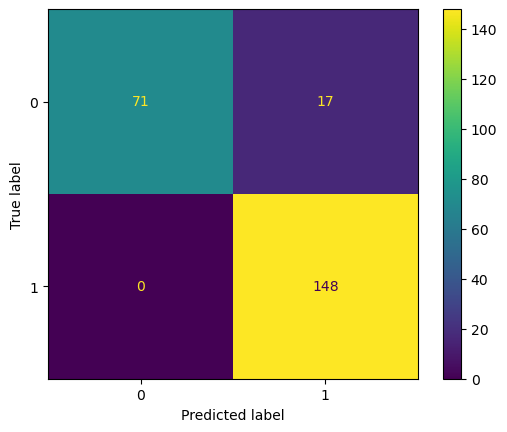

In [54]:
y_prob =  best_lr_night.predict_proba(X_test)[:, 1]
y_pred = (y_prob >= best_threshold).astype(int)
cm = confusion_matrix(Y_test,y_pred, labels= best_lr_day.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                           display_labels= best_lr_day.classes_)
disp.plot()

Mostriamo i dati sulla mappa di Trento

In [55]:
y_prob =  best_lr_night.predict_proba(scal.transform(X))[:, 1]
df_day_trento['PRED']=(y_prob >= best_threshold).astype(int)
df_day_trento.groupby(["SQUAREID","HIGH_POW"])[["PRED"]].mean().reset_index()

,SQUAREID,HIGH_POW,PRED
0,4850,0,1.0
1,4850,1,1.0
2,4966,0,1.0
3,4966,1,1.0
4,4967,1,1.0
5,4968,0,1.0
6,4968,1,1.0
7,5082,0,0.0
8,5083,1,1.0
9,5084,1,1.0


In [56]:
import geopandas as gpd
df_grid = gp.read_file("./data_trentino/raw/trentino-grid.geojson")
df_grid = df_grid.rename(columns={"cellId": "SQUAREID"})
df_grid[['SQUAREID','geometry']]
df_grid=df_grid.merge(df_day_trento[["SQUAREID","HIGH_POW",'PRED']],on='SQUAREID',how='left')
df_grid

,SQUAREID,geometry,HIGH_POW,PRED
0,38,"POLYGON ((10.91462 45.68201, 10.92746 45.68179...",NaN,NaN
1,39,"POLYGON ((10.92746 45.68179, 10.94029 45.68157...",NaN,NaN
2,40,"POLYGON ((10.94029 45.68157, 10.95312 45.68136...",NaN,NaN
3,154,"POLYGON ((10.90209 45.69122, 10.91493 45.69100...",NaN,NaN
4,155,"POLYGON ((10.91493 45.69100, 10.92777 45.69079...",NaN,NaN
...,...,...,...,...
7718,11336,"POLYGON ((11.80475 46.52767, 11.81777 46.52735...",NaN,NaN
7719,11337,"POLYGON ((11.81777 46.52735, 11.83080 46.52703...",NaN,NaN
7720,11452,"POLYGON ((11.79219 46.53698, 11.80521 46.53666...",NaN,NaN
7721,11453,"POLYGON ((11.80521 46.53666, 11.81824 46.53634...",NaN,NaN


In [57]:
df_grid['Category'] = 'Unknown'  

df_grid.loc[(df_grid['HIGH_POW'] > 0.5) & (df_grid['PRED'] > 0.5), 'Category'] = 'Real Positive'
df_grid.loc[(df_grid['HIGH_POW'] > 0.5) & (df_grid['PRED'] < 0.5), 'Category'] = 'False Negative'
df_grid.loc[(df_grid['HIGH_POW'] <0.5) & (df_grid['PRED'] > 0.5), 'Category'] = 'False Positive'
df_grid.loc[(df_grid['HIGH_POW'] < 0.5) & (df_grid['PRED'] < 0.5), 'Category'] = 'Real Negative'

df_grid.dropna(inplace=True)

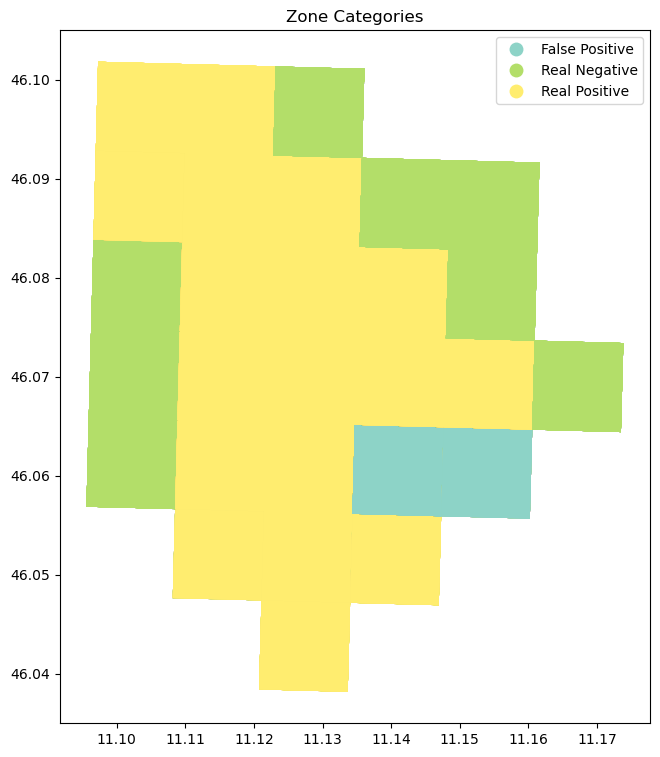

In [58]:
import matplotlib.patches as mpatches
fig, ax = plt.subplots(figsize=(9, 9))

df_grid.plot(column='Category', legend=True,ax=ax, cmap='Set3')

ax.set_title('Zone Categories')

# Plot the custom legend

plt.show()

La mappa ottenuta coincide con quella ottenuta in precedenza. Concludiamo che è possibile ottenere gli stessi risultati indipendentemente dalla fascia giornaliera e quella notturna. Proviamo adesso ad utilizzare una fascia oraria più restritiva (18-19)

In [66]:
df_18_19_trento_nov=pd.read_csv("class/df_18_19_trento_nov.csv")
df_18_19_trento_nov.drop(columns=['Unnamed: 0','SAB','DOM','TRENTO'],inplace=True)
df_18_19_trento_dec=pd.read_csv("class/df_18_19_trento_nov.csv")
df_18_19_trento_dec.drop(columns=['Unnamed: 0','SAB','DOM','TRENTO'],inplace=True)
df_18_19_trento=pd.concat([df_18_19_trento_nov, df_18_19_trento_dec], ignore_index=True)
df_18_19_trento=df_18_19_trento[df_18_19_trento['DAY_ID']<5]
df_18_19_trento

,SQUAREID,DAY,DAY_ID,LUN,MAR,MER,GIO,VEN,SQUARE_UBICAZIONI,NR_LINES,DAWN,SUNSET,DAYLENGHT,minTemperature,maxTemperature,POWER,HIGH_POW
0,4850,1,4,0,0,0,0,1,285,5,417,1020,603,11.7,16.0,22.222965,0
3,4850,4,0,1,0,0,0,0,285,5,421,1016,594,7.4,9.8,25.444795,1
4,4850,5,1,0,1,0,0,0,285,5,422,1014,592,7.5,15.4,24.618746,1
5,4850,6,2,0,0,1,0,0,285,5,424,1013,589,7.9,14.3,24.419332,1
6,4850,7,3,0,0,0,1,0,285,5,425,1012,586,6.1,15.6,25.166574,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1674,5552,25,0,1,0,0,0,0,133,1,450,994,543,2.4,10.4,9.587340,0
1675,5552,26,1,0,1,0,0,0,133,1,451,993,541,2.4,6.7,9.649588,0
1676,5552,27,2,0,0,1,0,0,133,1,453,992,539,-0.3,4.9,9.671775,0
1677,5552,28,3,0,0,0,1,0,133,1,454,992,538,-2.6,5.0,9.502905,0


In [67]:
df_18_19_trento.isnull().sum()

SQUAREID             0
DAY                  0
DAY_ID               0
LUN                  0
MAR                  0
MER                  0
GIO                  0
VEN                  0
SQUARE_UBICAZIONI    0
NR_LINES             0
DAWN                 0
SUNSET               0
DAYLENGHT            0
minTemperature       0
maxTemperature       0
POWER                0
HIGH_POW             0
dtype: int64

In [68]:
X=df_18_19_trento.drop(columns=['SQUAREID','POWER','DAY','DAWN','SUNSET','HIGH_POW'])
scal = StandardScaler()
Y=df_18_19_trento['HIGH_POW']
X_train,X_other,Y_train,Y_other=train_test_split(X,Y,test_size=0.4,random_state=0)
X_valid = X_other[:len(X_other)//2]
X_test = X_other[len(X_other)//2:]
Y_valid = Y_other[:len(Y_other)//2]
Y_test = Y_other[len(Y_other)//2:]
scal.fit(X)
X_train=scal.transform(X_train)
X_valid=scal.transform(X_valid)
X_test=scal.transform(X_test)


Creiamo il primo classificatore con regolarizzazione elasticnet e lo alleniamo con i dati di train

In [69]:
LR_18_19 = LogisticRegressionCV(penalty='elasticnet',solver='saga',l1_ratios=[0,0.25,0.5,0.75,1.0],max_iter=2000,tol=0.001,cv=20)

In [70]:
LR_18_19.fit(X_train,Y_train)


LogisticRegressionCV(cv=20, l1_ratios=[0, 0.25, 0.5, 0.75, 1.0], max_iter=2000,
                     penalty='elasticnet', solver='saga', tol=0.001)

Visualizziamo l'importanza delle features del modello tramite un istogramma

Text(0.5, 1.0, 'Pesi LR_night')

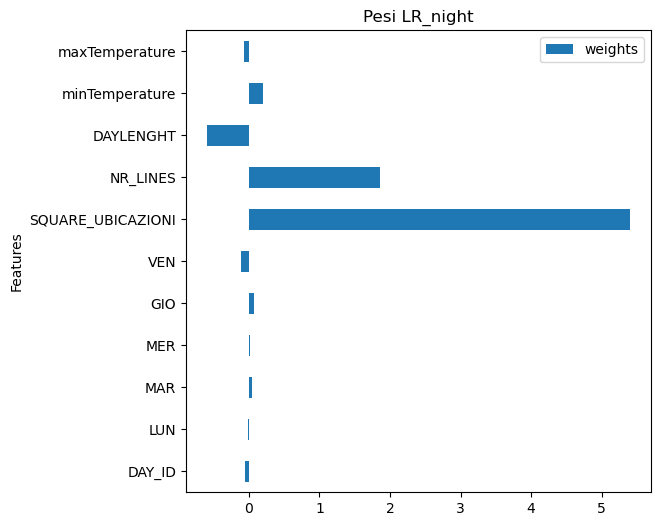

In [71]:
features = X.columns.to_numpy().reshape(-1)  # Trasformo l'array in un vettore unidimensionale
weights = LR_18_19.coef_.flatten()  
df_w = pd.DataFrame({'features': features, 'weights': weights})
ax = df_w.plot.barh(y='weights', x='features', figsize=(6, 6))
ax.set_ylabel('Features')
ax.set_title('Pesi LR_night')

L'importanza delle features ha un andamento molto simile ai modelli precedenti

Valutiamo il classificatore creato e creiamo la matrice di confusione

In [72]:
evaluate_classifier(LR_18_19, X_valid, Y_valid)

Accuracy: 0.8765957446808511
Precision: 0.8859060402684564
Recall: 0.9166666666666666
F1 Score: 0.901023890784983
True Positive Rate: 0.9166666666666666
False Positive Rate: 0.18681318681318682


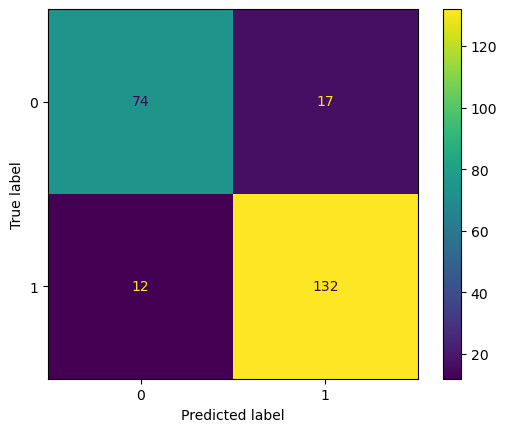

In [73]:
disp_cf(LR_18_19, X_valid, Y_valid)

In questo caso la matrice di confusione è identica a quella ottenuta precedentemente

Come fatto in precedenza,cerchiamo il modello ottimale tramite una GridSearch

Stampiamo i parametri del modello migliore

In [74]:
best_lr_18_19=train_regression_model(pipe_lr,param_grid,10,X_train,Y_train)

Best parameters: {'logreg__C': 0.0774263682681127, 'logreg__class_weight': 'balanced', 'logreg__penalty': 'l1', 'logreg__solver': 'saga'}


In [75]:
best_lr_18_19.score(X_valid,Y_valid)

0.902127659574468

In [76]:
evaluate_classifier(best_lr_18_19, X_valid, Y_valid)

Accuracy: 0.902127659574468
Precision: 0.9230769230769231
Recall: 0.9166666666666666
F1 Score: 0.9198606271777002
True Positive Rate: 0.9166666666666666
False Positive Rate: 0.12087912087912088


Confrontiamo le curve Roc e le Auc dei due classificatori

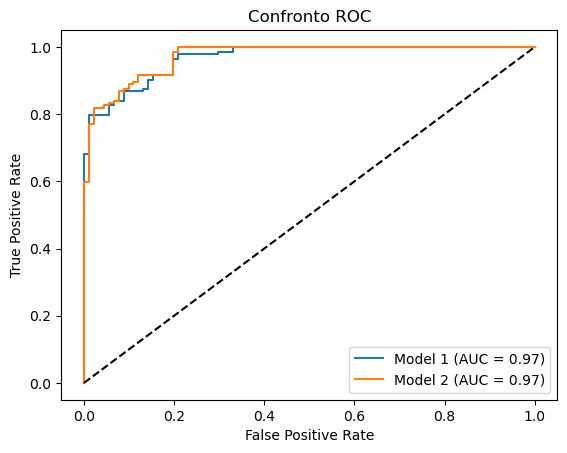

Model 1 AUC: 0.9676434676434675
Model 2 AUC: 0.9718406593406593


In [77]:
plot_roc_curve(LR_18_19, best_lr_18_19, X_valid, Y_valid)

Anche in questo caso il modello trovato con la GridSearch è leggermente migliore rispetto a 'LR_18_19'

In [79]:
pr,rec, th = precision_recall_curve(Y_valid,  best_lr_18_19.predict_proba(X_valid)[:,1])

Visualizziamo adesso l'andamento della precisione e della recall in funzione della threshold

Text(0, 0.5, 'recall')

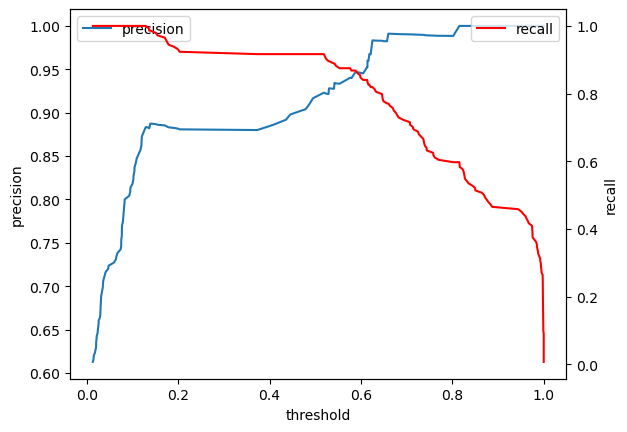

In [80]:
ax = sns.lineplot(x=th, y =pr[:-1], label='precision')
ax2 = sns.lineplot(x=th,y=rec[:-1],label='recall',ax=ax.twinx(),color='red')
ax.set_xlabel('threshold')
ax.set_ylabel('precision')
ax2.set_ylabel('recall')

Come fatto in precedenza,cerchiamo la soglia che masimizza lo score f1

In [81]:
f1_scores = 2 * (pr * rec) / (pr + rec)
best_threshold = th[np.argmax(f1_scores)]
print("Best Threshold:", best_threshold)

Best Threshold: 0.12869572135472737


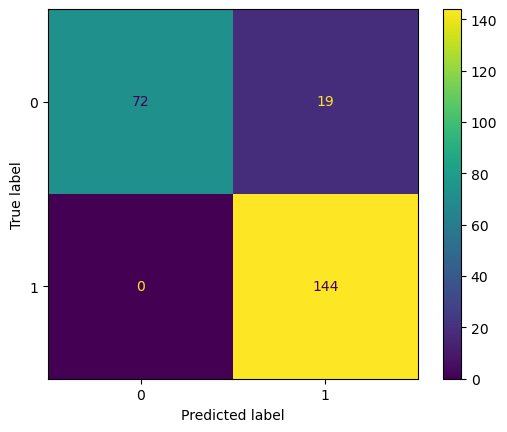

In [82]:
y_prob =  best_lr_18_19.predict_proba(X_valid)[:, 1]
y_pred = (y_prob >= best_threshold).astype(int)
cm = confusion_matrix(Y_valid,y_pred, labels= best_lr_day.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                           display_labels= best_lr_day.classes_)
disp.plot()

A questo punto rifacciamo il train su l'insieme train + valid, e valutiamo il modello confrontandolo con i dati test

In [83]:
X_final=np.concatenate([X_train, X_valid])
Y_final=np.concatenate([Y_train, Y_valid])
best_lr_18_19.fit(X_final,Y_final)

Pipeline(steps=[('scaler', StandardScaler()),
                ('logreg',
                 LogisticRegression(C=0.0774263682681127,
                                    class_weight='balanced', max_iter=2000,
                                    penalty='l1', solver='saga'))])

In [84]:
evaluate_classifier(best_lr_18_19, X_test, Y_test)

Accuracy: 0.8983050847457628
Precision: 0.9246575342465754
Recall: 0.9121621621621622
F1 Score: 0.9183673469387755
True Positive Rate: 0.9121621621621622
False Positive Rate: 0.125


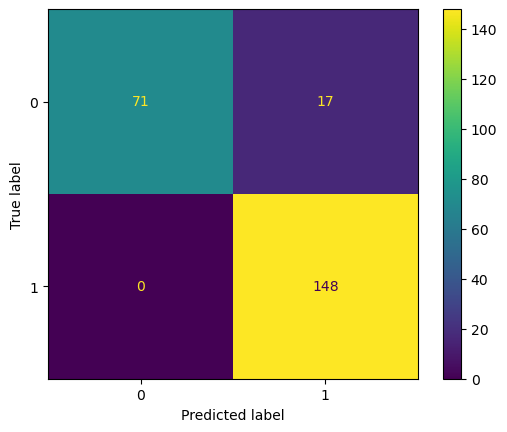

In [85]:
y_prob =  best_lr_18_19.predict_proba(X_test)[:, 1]
y_pred = (y_prob >= best_threshold).astype(int)
cm = confusion_matrix(Y_test,y_pred, labels= best_lr_day.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                           display_labels= best_lr_day.classes_)
disp.plot()

Mostriamo i dati sulla mappa di Trento

In [86]:
y_prob =  best_lr_18_19.predict_proba(scal.transform(X))[:, 1]
df_day_trento['PRED']=(y_prob >= best_threshold).astype(int)
df_day_trento.groupby(["SQUAREID","HIGH_POW"])[["PRED"]].mean().reset_index()

,SQUAREID,HIGH_POW,PRED
0,4850,0,1.0
1,4850,1,1.0
2,4966,0,1.0
3,4966,1,1.0
4,4967,1,1.0
5,4968,0,1.0
6,4968,1,1.0
7,5082,0,0.0
8,5083,1,1.0
9,5084,1,1.0


In [87]:
import geopandas as gpd
df_grid = gp.read_file("./data_trentino/raw/trentino-grid.geojson")
df_grid = df_grid.rename(columns={"cellId": "SQUAREID"})
df_grid[['SQUAREID','geometry']]
df_grid=df_grid.merge(df_day_trento[["SQUAREID","HIGH_POW",'PRED']],on='SQUAREID',how='left')
df_grid

,SQUAREID,geometry,HIGH_POW,PRED
0,38,"POLYGON ((10.91462 45.68201, 10.92746 45.68179...",NaN,NaN
1,39,"POLYGON ((10.92746 45.68179, 10.94029 45.68157...",NaN,NaN
2,40,"POLYGON ((10.94029 45.68157, 10.95312 45.68136...",NaN,NaN
3,154,"POLYGON ((10.90209 45.69122, 10.91493 45.69100...",NaN,NaN
4,155,"POLYGON ((10.91493 45.69100, 10.92777 45.69079...",NaN,NaN
...,...,...,...,...
7718,11336,"POLYGON ((11.80475 46.52767, 11.81777 46.52735...",NaN,NaN
7719,11337,"POLYGON ((11.81777 46.52735, 11.83080 46.52703...",NaN,NaN
7720,11452,"POLYGON ((11.79219 46.53698, 11.80521 46.53666...",NaN,NaN
7721,11453,"POLYGON ((11.80521 46.53666, 11.81824 46.53634...",NaN,NaN


In [88]:
df_grid['Category'] = 'Unknown'  

df_grid.loc[(df_grid['HIGH_POW'] > 0.5) & (df_grid['PRED'] > 0.5), 'Category'] = 'Real Positive'
df_grid.loc[(df_grid['HIGH_POW'] > 0.5) & (df_grid['PRED'] < 0.5), 'Category'] = 'False Negative'
df_grid.loc[(df_grid['HIGH_POW'] <0.5) & (df_grid['PRED'] > 0.5), 'Category'] = 'False Positive'
df_grid.loc[(df_grid['HIGH_POW'] < 0.5) & (df_grid['PRED'] < 0.5), 'Category'] = 'Real Negative'

df_grid.dropna(inplace=True)

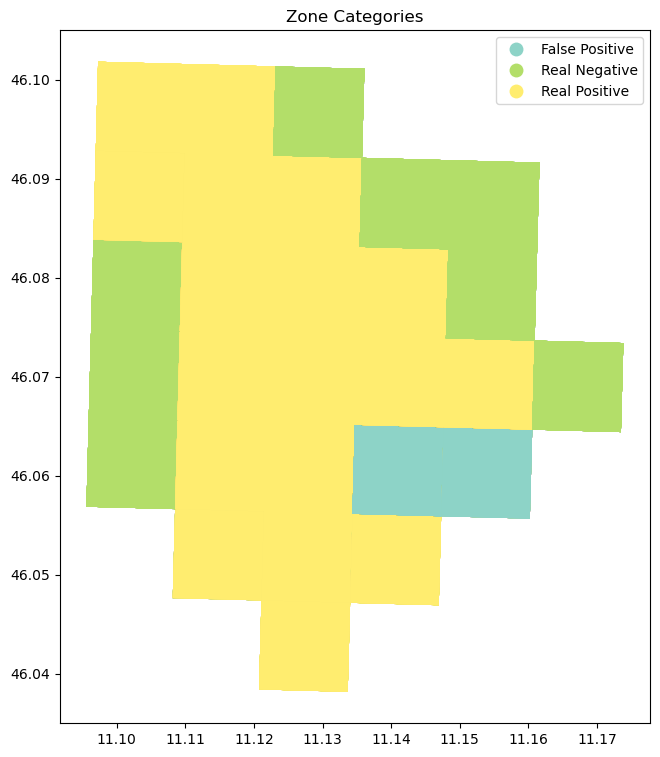

In [89]:
import matplotlib.patches as mpatches
fig, ax = plt.subplots(figsize=(9, 9))

df_grid.plot(column='Category', legend=True,ax=ax, cmap='Set3')

ax.set_title('Zone Categories')

# Plot the custom legend

plt.show()

Nonostante l'utilizzo di una fascia oraria più restrittiva, i dati ottenuti sono in linea con quelli precedenti. Questo risultato suggerisce che la riduzione della fascia oraria non ha influenzato in modo significativo le previsioni del modello. Considerando che i sei modelli testati sono equivalenti in termini di prestazioni, è sufficiente salvare soltanto due dei modelli per mantenere una rappresentazione adeguata del modello migliore. 

In [90]:
from joblib import dump, load

In [92]:
models = {'LR':{'filename':'LR.pkl','value':LR_day},
            'Best_lr':{'filename':'Best_lr.pkl','value':best_lr_day}}
dump(models['LR']['value'],models['LR']['filename'])
pklfiles = [dump(**mod) for mod in models.values()]